In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/OneDrive/Documents/Injury Dataset/2013-2022/2018-2022 Data Cleaned Trainable.csv')
data = pd.DataFrame(dataset.iloc[:,:22])
print(data.STATE)

X = pd.DataFrame(dataset.iloc[:,:22].values)
Y = np.array(pd.DataFrame(dataset.iloc[:,22:].values))
Y = Y.reshape(-1)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

0        1
1        1
2        1
3        1
4        1
        ..
44090    2
44091    2
44092    2
44093    2
44094    2
Name: STATE, Length: 44095, dtype: int64
       0   1   2   3   4   5   6   7   8   9   ...  12  13  14   15  16  17  \
0       1   1   1   1   0   1   3  55   1   1  ...   0   0   1    0   0   1   
1       1   1   1   1   0   1   0  16   1   1  ...   0   0   1    0   0   1   
2       1   1   1   1   3   0   3  41   1   1  ...   0   1   1    0   1   1   
3       1   1   2   2   3   0   0  21   2   1  ...   0   0   1    0   0   1   
4       1   1   2   1   3   0   1  66   1   1  ...   0   0   1  174   0   1   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ...  ..  ..   
44090   2   4   1   2   0   1   0  53   1   1  ...   1   0   1    0   0   1   
44091   2   4   1   2   0   1   2  27   1   1  ...   1   0   1    0   1   1   
44092   2   4   1   2   1   0   1  25   1   1  ...   1   1   1  155   0   1   
44093   2   4   1   2   1   0   1  21   2   1  .

In [2]:
features = pd.DataFrame(dataset.iloc[:,:32])
features = features.columns
print(features)

Index(['STATE', 'SEASON', 'DAY', 'HOUR', 'HARM_EV', 'MAN_COLL', 'BODY_TYP',
       'AGE', 'GENDER', 'PER_TYP', 'SEAT_POS', 'REST_USE', 'AIR_BAG',
       'DRINKING', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DSTATUS', 'ETHNICITY ',
       'RUR_URB', 'FUNC_SYS', 'IMPACT1', 'INJ_SEV'],
      dtype='object')


In [3]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 

In [4]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, 'sqrt', 'log2'])

    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 2.0, log=True)

    clf = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, Y_train, cv=cv, scoring='accuracy')

    return np.mean(scores)

study = optuna.create_study(study_name = "Adaboost", direction="maximize",storage="sqlite:///adaboost.db")
study.optimize(objective, n_trials=50)

print("Best Accuracy:", study.best_value)
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

c:\Users\eddie\anaconda3\envs\SSTP-Injury\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-30 18:03:05,660] A new study created in RDB with name: Adaboost
[I 2025-05-30 18:03:11,029] Trial 0 finished with value: 0.9209661173706429 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None, 'n_estimators': 75, 'learning_rate': 0.5373016303489795}. Best is trial 0 with value: 0.9209661173706429.
[I 2025-05-30 18:03:58,593] Trial 1 finished with value: 0.9067355255355153 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': None, 'n_estimators': 240, 'learning_rate': 0.5085426613130227}. Best is trial 0 with value: 0.9209661173706429.
[I 2025-05-30 18:04:22,262] Trial 2 finished with value: 0.9248215149513619 and parameter

Best Accuracy: 0.9258136708498661
Best Hyperparameters:
  max_depth: 4
  min_samples_split: 11
  min_samples_leaf: 5
  max_features: log2
  n_estimators: 235
  learning_rate: 0.05650121460182989


In [5]:
model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth = 5,min_samples_split = 16,min_samples_leaf = 5,max_features = "log2"),
        n_estimators = 22,
        learning_rate = 0.02160250512283948
)
model.fit(X_train, Y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    max_features='log2',
                                                    min_samples_leaf=5,
                                                    min_samples_split=16),
                   learning_rate=0.02160250512283948, n_estimators=22)

In [6]:
res = model.predict(X_test)
print(res)
print(Y_test)

[0 1 2 ... 2 2 2]
[0 1 2 ... 2 2 2]


In [7]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test,res)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

0.9171107835355482
              precision    recall  f1-score   support

           0   0.801636  0.727723  0.762893      1616
           1   0.758109  0.825749  0.790484      1670
           2   1.000000  1.000000  1.000000      5533

    accuracy                       0.917111      8819
   macro avg   0.853248  0.851157  0.851126      8819
weighted avg   0.917846  0.917111  0.916878      8819



PermutationExplainer explainer: 8820it [06:26, 22.28it/s]                          
C:\Users\eddie\AppData\Local\Temp\ipykernel_38840\1552002207.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)


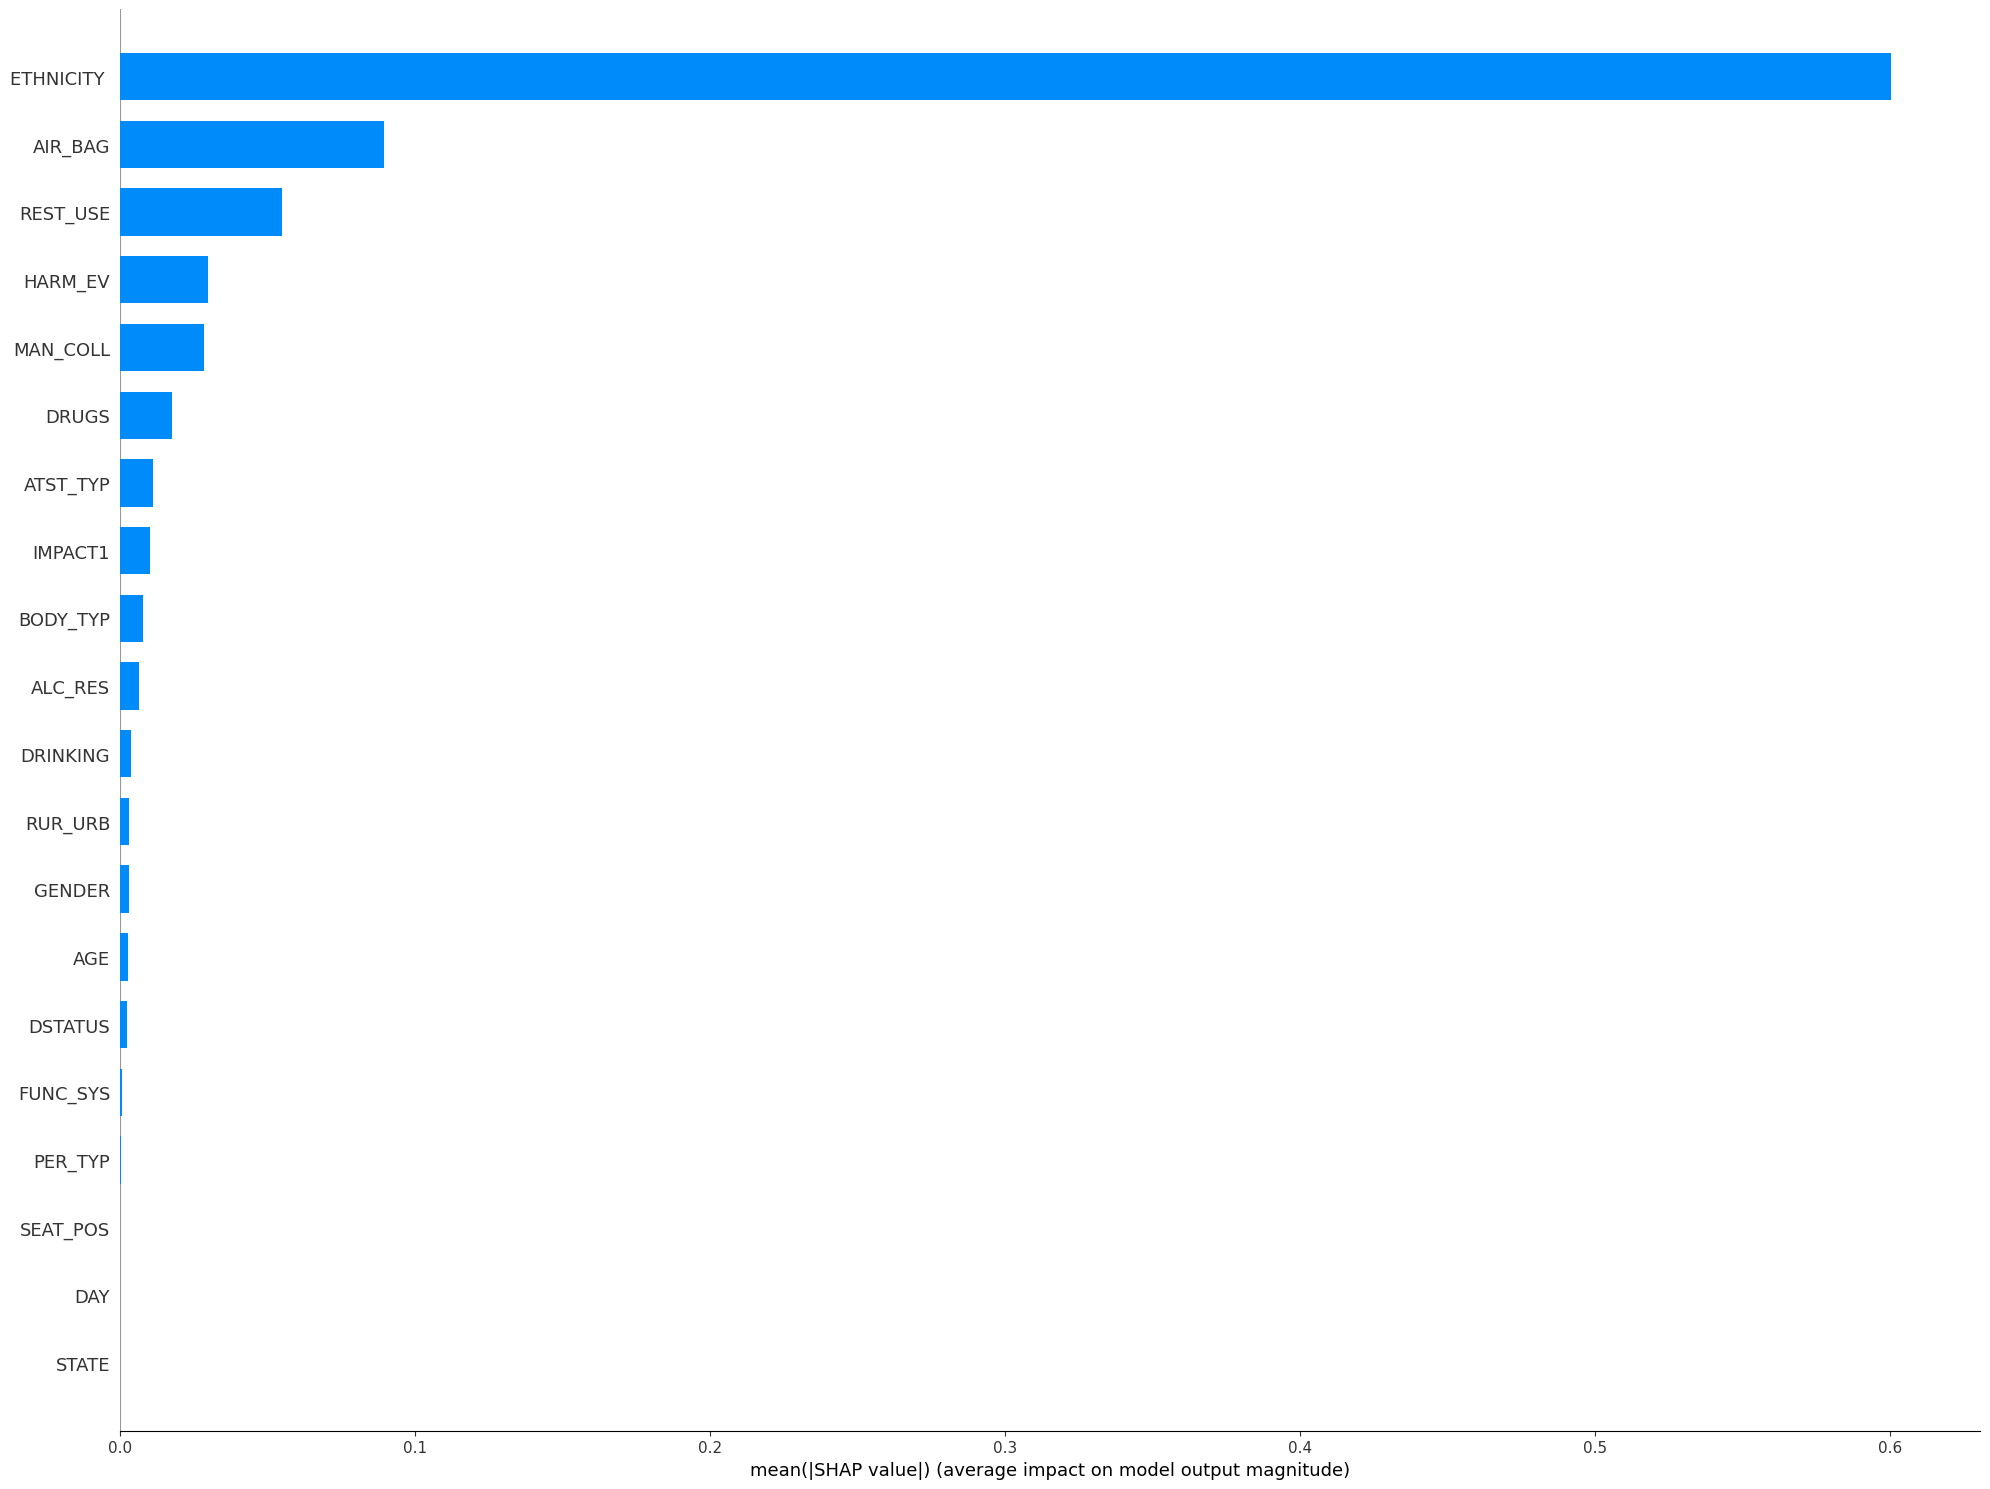

In [8]:
import shap 
explainer = shap.Explainer(model.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)

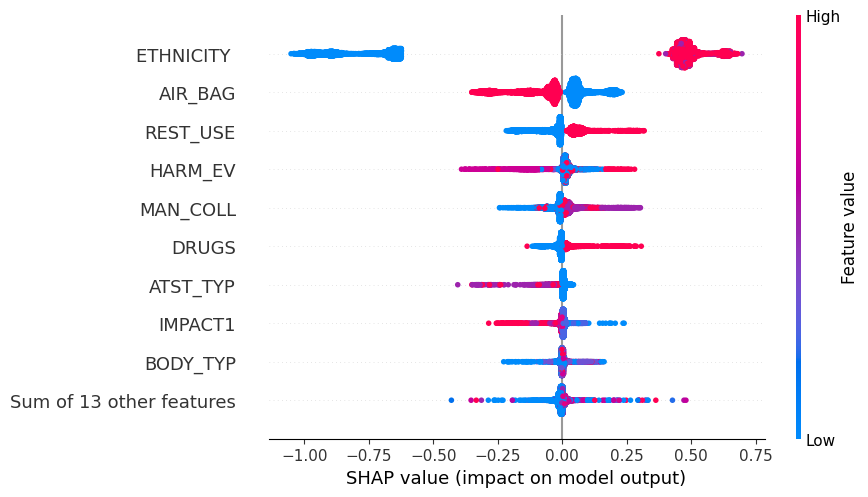

In [9]:
explanation = shap.Explanation(
    values=shap_values, 
    feature_names=features
)
shap.plots.beeswarm(explanation)

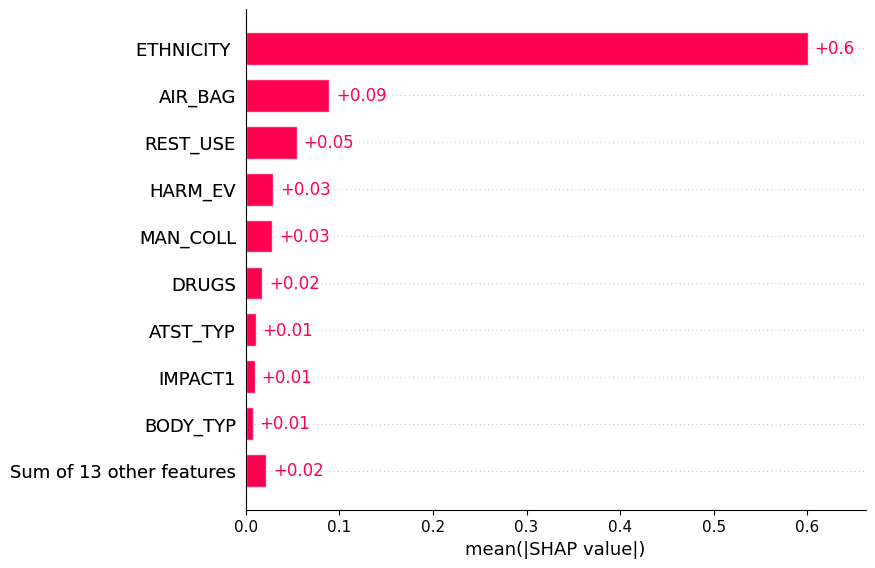

In [10]:
shap.plots.bar(explanation)

In [21]:
import matplotlib.pyplot as plt
import os

indices = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
for i in indices:
    shap.plots.waterfall(explanation[i], show=False)
    plt.savefig(os.path.join("shap/adaboost/waterfall", f"waterfall_{i}.png"), dpi = 300,bbox_inches="tight")
    plt.close()


In [41]:
import matplotlib.pyplot as plt
import os

indices = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
for i in indices:
    # shap.plots.waterfall(explanation[i], show=False)
    # shap.initjs()
    shap.force_plot(shap_values[i],feature_names=['STATE', 'SEASON', 'DAY', 'HOUR', 'HARM_EV', 'MAN_COLL', 'BODY_TYP', 'AGE', 'GENDER', 'PER_TYP', 'SEAT_POS', 'REST_USE', 'AIR_BAG', 'DRINKING', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DSTATUS', 'ETHNICITY ', 'RUR_URB', 'FUNC_SYS', 'IMPACT1'], matplotlib=True, show=False)
    plt.savefig(os.path.join("shap/adaboost/force/", f"force_{i}.png"), dpi = 300,bbox_inches="tight")
    # shap.save_html(os.path.join("shap/adaboost/force/", f"force_{i}.png"), force_plot)
    plt.close()


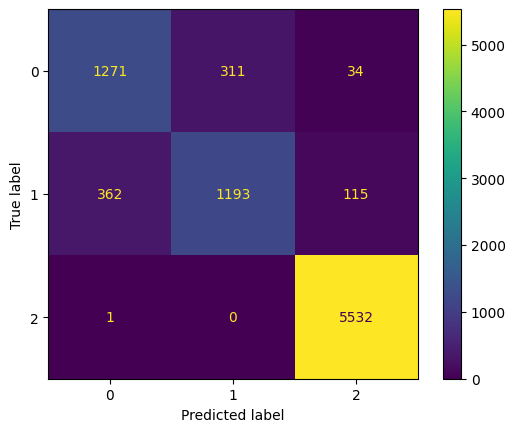

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix)
cm_display.plot()